## Fusing of weights and Norms
We start by fusing the weights as described in the lecture. Therefore, we first compute the time the network needs for inference before fusing the weights so we can compare them later.

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tinyyolov2 import TinyYoloV2
from tinyyolov2_fused import TinyYoloV2Fused
from utils.yolo import nms, filter_boxes
from utils.viz import display_result
from utils.ap import precision_recall_levels, ap
from utils.dataloader import VOCDataLoader

device = ''
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Nutze CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Nutze Apple MPS")
else:
    device = torch.device("cpu")
    print("Nutze CPU")

# Loader initialisieren
loader = VOCDataLoader(train=False, batch_size=1)

# Originales Modell laden
net = TinyYoloV2(num_classes=20)
net.to(device)
sd = torch.load("voc_pretrained.pt", map_location=device, weights_only=False)
net.load_state_dict(sd)
net.eval()

# Hilfsfunktion für die Genauigkeitsmessung
def evaluate_model_accuracy(model, test_loader, num_samples=100):
    model.eval()
    test_precision = []
    test_recall = []
    
    print(f"Berechne Average Precision für {num_samples} Bilder...")
    with torch.no_grad():
        for idx, (input, target) in tqdm.tqdm(enumerate(test_loader), total=num_samples):
            input, target = input.to(device), target.to(device)
            output = model(input, yolo=True)
            output = filter_boxes(output, 0.0)
            output = nms(output, 0.5)
            
            precision, recall = precision_recall_levels(target[0], output[0])
            test_precision.append(precision)
            test_recall.append(recall)
            
            if idx + 1 == num_samples:
                break
    return ap(test_precision, test_recall)

# Baseline-Messung: Zeit
data_iter = iter(loader)
img, target = next(data_iter)

img = img.to(device)

with torch.no_grad():
    _ = net(img, yolo=True) # Warm-up
    start_time = time.time()
    for _ in range(100):
        output_orig = net(img, yolo=True)
    latency_orig = (time.time() - start_time) / 100 * 1000

# Baseline-Messung: Accuracy (AP)
ap_orig = evaluate_model_accuracy(net, loader, num_samples=100)

output_ref = output_orig.clone()
results = {
    'Method': ['Original'],
    'Latency (ms)': [latency_orig],
    'AP Accuracy': [ap_orig]
}


Nutze CUDA: NVIDIA GeForce RTX 2070 SUPER
Berechne Average Precision für 100 Bilder...


 99%|█████████▉| 99/100 [00:16<00:00,  6.01it/s]


Now we do the actual fusing

In [88]:
# Fusion-Logik anwenden
def fuse_all_layers(orig_net, fused_net):
    def get_fused_params(conv, bn):
        w = conv.weight
        mean = bn.running_mean
        var_sqrt = torch.sqrt(bn.running_var + bn.eps)
        gamma = bn.weight
        beta = bn.bias
        w_f = w * (gamma / var_sqrt).reshape([-1, 1, 1, 1])
        b_f = beta - (gamma * mean / var_sqrt)
        return w_f, b_f

    for i in range(1, 9):
        w_f, b_f = get_fused_params(getattr(orig_net, f'conv{i}'), getattr(orig_net, f'bn{i}'))
        getattr(fused_net, f'conv{i}').weight.data.copy_(w_f)
        getattr(fused_net, f'conv{i}').bias.data.copy_(b_f)
    fused_net.conv9.load_state_dict(orig_net.conv9.state_dict())

net_fused = TinyYoloV2Fused(num_classes=20)
net_fused.to(device)
fuse_all_layers(net, net_fused)
net_fused.eval()

TinyYoloV2Fused(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(1024, 125, kernel_size=(1, 1), stride=(1, 1))
)

Now we verify what the fusing actually did to the networks performance and the inference time.

In [89]:
with torch.no_grad():
    _ = net_fused(img, yolo=True)
    start = time.time()
    for _ in range(100):
        output_fused = net_fused(img, yolo=True)
    latency_fused = (time.time() - start) / 100 * 1000

ap_fused = evaluate_model_accuracy(net_fused, loader, num_samples=100)
diff = (output_ref - output_fused).abs().max()

results['Method'].append('Fused (Optimized)')
results['Latency (ms)'].append(latency_fused)
results['AP Accuracy'].append(ap_fused)

Berechne Average Precision für 100 Bilder...


 99%|█████████▉| 99/100 [00:16<00:00,  5.90it/s]


Finnaly we visulaize the results of the operation.


Maximaler Output-Unterschied: 3.04e-06


,Method,Latency (ms),AP Accuracy
0,Original,1.760530,0.595841
1,Fused (Optimized),1.651323,0.595841


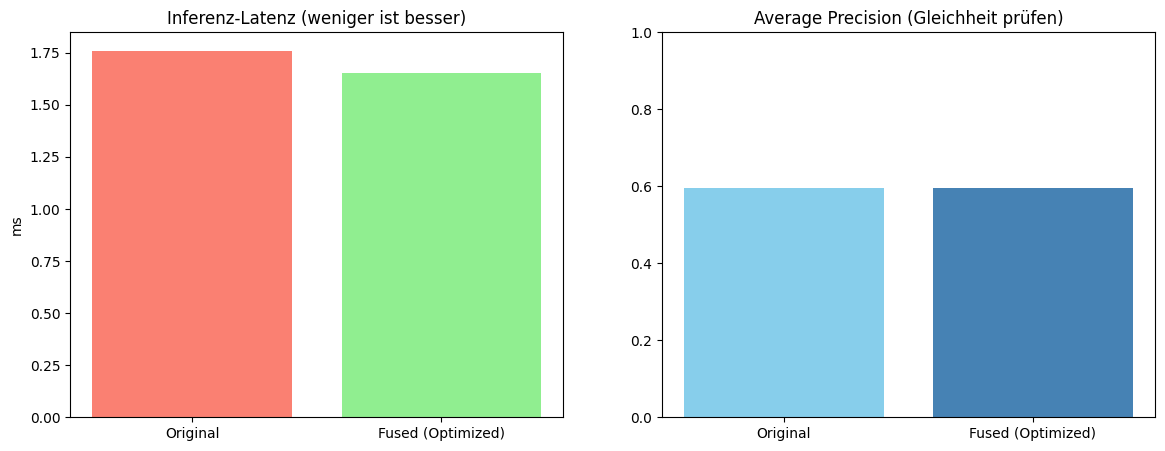

In [90]:
print(f"\nMaximaler Output-Unterschied: {diff:.2e}")
df = pd.DataFrame(results)
display(df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.bar(results['Method'], results['Latency (ms)'], color=['salmon', 'lightgreen'])
ax1.set_title('Inferenz-Latenz (weniger ist besser)')
ax1.set_ylabel('ms')

ax2.bar(results['Method'], results['AP Accuracy'], color=['skyblue', 'steelblue'])
ax2.set_title('Average Precision (Gleichheit prüfen)')
ax2.set_ylim(0, 1.0)
plt.show()

# Modell für Jetson Nano speichern
torch.save(net_fused.state_dict(), "voc_fused.pt")

## Person Only Detection
We continue by finetuning the network to detect the person class only instead of e.g. 20 classes it detected before.
Zuerst laden wir den spezialisierten Dataloader und initialisieren das Modell mit nur einer Klasse (num_classes=1).

In [ ]:
from utils.dataloader import VOCDataLoaderPerson
from utils.loss import YoloLoss
import torch.optim as optim

# 1. Spezialisierte Dataloader laden
train_loader = VOCDataLoaderPerson(train=True, batch_size=64, shuffle=True)
test_loader_person = VOCDataLoaderPerson(train=False, batch_size=1)

# 2. Modell für 1 Klasse initialisieren (basiert auf deiner TinyYoloV2Fused Klasse)
net_person = TinyYoloV2Fused(num_classes=1)
net_person.to(device)

# 3. Gewichte des gefusten 20-Klassen-Modells laden
# WICHTIG: Wir laden alles außer 'conv9', da sich dort die Form von 125 auf 30 Kanäle ändert.
fused_sd = torch.load("voc_fused.pt",map_location=device, weights_only=False)
net_person.load_state_dict({k: v for k, v in fused_sd.items() if 'conv9' not in k}, strict=False)

# 4. Layer einfrieren: Wir trainieren nur die neue Schicht 'conv9'
for name, param in net_person.named_parameters():
    if 'conv9' not in name:
        param.requires_grad = False

# 5. Optimizer und Loss-Funktion definieren
optimizer = optim.Adam(net_person.conv9.parameters(), lr=0.001)
criterion = YoloLoss(anchors=net_person.anchors)

Nun trainieren wir das modell für einige Epochen nur auf der Klasse die uns interessiert -> Personen

In [92]:
import torch.optim.lr_scheduler as lr_scheduler
import copy

def evaluate_person_accuracy(model, test_loader, num_classes_model, num_samples=100):
    model.eval()
    test_precision = []
    test_recall = []
    
    # In VOC ist Person Index 14. Im Person-Only Modell ist es Index 0
    PERSON_CLASS_ID = 14 if num_classes_model == 20 else 0 

    print(f"Evaluiere {'Original' if num_classes_model==20 else 'Fine-Tuned'} auf Personen-Testset...")
    with torch.no_grad():
        for idx, (input, target) in tqdm.tqdm(enumerate(test_loader), total=num_samples):
            input, target = input.to(device), target.to(device)
            output = model(input, yolo=True) #
            
            # 1. Filtern (Confidence > 0 für PR-Kurve)
            output_boxes = filter_boxes(output, 0.0) 
            
            # 2. Speziell nach der Personen-Klasse filtern
            # Wir extrahieren nur Boxen der Klasse 'Person'
            filtered_boxes = []
            for box in output_boxes[0]:
                if int(box[-1]) == PERSON_CLASS_ID:
                    # Für den Vergleich mit dem Target (Klasse 0) mappen wir den Index auf 0
                    box_copy = box.clone()
                    box_copy[-1] = 0.0
                    filtered_boxes.append(box_copy)
            
            # Liste wieder in Tensor umwandeln
            if len(filtered_boxes) > 0:
                output_boxes = [torch.stack(filtered_boxes)]
            else:
                output_boxes = [torch.zeros((0, 7))]
            
            # 3. NMS anwenden
            output_final = nms(output_boxes, 0.5)
            
            # 4. PR-Levels berechnen
            precision, recall = precision_recall_levels(target[0], output_final[0])
            test_precision.append(precision)
            test_recall.append(recall)
            
            if idx + 1 == num_samples: break
                
    return ap(test_precision, test_recall)

num_epochs = 30
eval_samples = 100
best_ap = -1.0
best_model_sd = None

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=1e-4)

net_person.train()

print("Starte Person-only Fine-Tuning...")
for epoch in range(num_epochs):
    running_loss = 0.0
    for idx, (inputs, targets) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        outputs = net_person(inputs, yolo=False)
        loss, _ = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)

    current_ap = evaluate_person_accuracy(
        net_person, 
        test_loader_person, 
        num_classes_model=1, 
        num_samples=eval_samples
    )

    print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f} and Avg precision: {current_ap:.4f}")
    
    if current_ap > best_ap:
        best_ap = current_ap
        best_model_sd = copy.deepcopy(net_person.state_dict())
        torch.save(best_model_sd, "best_person_model.pt")
        print(f"New best AP: {best_ap:.4f} (Modell saved)")
    else:
        print(f"   AP: {current_ap:.4f} (Best so far: {best_ap:.4f})")

    scheduler.step(avg_loss)

    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"--- Epoche {epoch+1} beendet | Avg Loss: {avg_loss:.4f} | Aktuelle LR: {current_lr:.6f} ---")
    

net_person.eval()

Starte Person-only Fine-Tuning...


100%|██████████| 34/34 [00:15<00:00,  2.18it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:15<00:00,  6.31it/s]


Epoch 1/30 - Avg Loss: 12.0957 and Avg precision: 0.1679
New best AP: 0.1679 (Modell saved)
--- Epoche 1 beendet | Avg Loss: 12.0957 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.20it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:15<00:00,  6.49it/s]


Epoch 2/30 - Avg Loss: 4.1106 and Avg precision: 0.2780
New best AP: 0.2780 (Modell saved)
--- Epoche 2 beendet | Avg Loss: 4.1106 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.19it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:15<00:00,  6.39it/s]


Epoch 3/30 - Avg Loss: 3.2904 and Avg precision: 0.3502
New best AP: 0.3502 (Modell saved)
--- Epoche 3 beendet | Avg Loss: 3.2904 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.20it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:15<00:00,  6.41it/s]


Epoch 4/30 - Avg Loss: 2.8819 and Avg precision: 0.3770
New best AP: 0.3770 (Modell saved)
--- Epoche 4 beendet | Avg Loss: 2.8819 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.19it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:15<00:00,  6.44it/s]


Epoch 5/30 - Avg Loss: 2.6041 and Avg precision: 0.3889
New best AP: 0.3889 (Modell saved)
--- Epoche 5 beendet | Avg Loss: 2.6041 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.20it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:15<00:00,  6.34it/s]


Epoch 6/30 - Avg Loss: 2.4165 and Avg precision: 0.4395
New best AP: 0.4395 (Modell saved)
--- Epoche 6 beendet | Avg Loss: 2.4165 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.18it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:16<00:00,  6.12it/s]


Epoch 7/30 - Avg Loss: 1.8536 and Avg precision: 0.4659
New best AP: 0.4659 (Modell saved)
--- Epoche 7 beendet | Avg Loss: 1.8536 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.23it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:17<00:00,  5.67it/s]


Epoch 8/30 - Avg Loss: 1.8038 and Avg precision: 0.4885
New best AP: 0.4885 (Modell saved)
--- Epoche 8 beendet | Avg Loss: 1.8038 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.17it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:17<00:00,  5.65it/s]


Epoch 9/30 - Avg Loss: 1.7724 and Avg precision: 0.4935
New best AP: 0.4935 (Modell saved)
--- Epoche 9 beendet | Avg Loss: 1.7724 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.18it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:17<00:00,  5.82it/s]


Epoch 10/30 - Avg Loss: 1.7375 and Avg precision: 0.5480
New best AP: 0.5480 (Modell saved)
--- Epoche 10 beendet | Avg Loss: 1.7375 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:16<00:00,  2.06it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.33it/s]


Epoch 11/30 - Avg Loss: 1.6970 and Avg precision: 0.5712
New best AP: 0.5712 (Modell saved)
--- Epoche 11 beendet | Avg Loss: 1.6970 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:16<00:00,  2.10it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.36it/s]


Epoch 12/30 - Avg Loss: 1.6674 and Avg precision: 0.5644
   AP: 0.5644 (Best so far: 0.5712)
--- Epoche 12 beendet | Avg Loss: 1.6674 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.15it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.46it/s]


Epoch 13/30 - Avg Loss: 1.6470 and Avg precision: 0.5644
   AP: 0.5644 (Best so far: 0.5712)
--- Epoche 13 beendet | Avg Loss: 1.6470 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.14it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:17<00:00,  5.66it/s]


Epoch 14/30 - Avg Loss: 1.6120 and Avg precision: 0.5747
New best AP: 0.5747 (Modell saved)
--- Epoche 14 beendet | Avg Loss: 1.6120 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:16<00:00,  2.10it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:19<00:00,  5.19it/s]


Epoch 15/30 - Avg Loss: 1.5924 and Avg precision: 0.5895
New best AP: 0.5895 (Modell saved)
--- Epoche 15 beendet | Avg Loss: 1.5924 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.14it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.21it/s]


Epoch 16/30 - Avg Loss: 1.5590 and Avg precision: 0.5698
   AP: 0.5698 (Best so far: 0.5895)
--- Epoche 16 beendet | Avg Loss: 1.5590 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.16it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.32it/s]


Epoch 17/30 - Avg Loss: 1.5283 and Avg precision: 0.6415
New best AP: 0.6415 (Modell saved)
--- Epoche 17 beendet | Avg Loss: 1.5283 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.15it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.22it/s]


Epoch 18/30 - Avg Loss: 1.4966 and Avg precision: 0.6320
   AP: 0.6320 (Best so far: 0.6415)
--- Epoche 18 beendet | Avg Loss: 1.4966 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.14it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.24it/s]


Epoch 19/30 - Avg Loss: 1.4683 and Avg precision: 0.6281
   AP: 0.6281 (Best so far: 0.6415)
--- Epoche 19 beendet | Avg Loss: 1.4683 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.19it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.36it/s]


Epoch 20/30 - Avg Loss: 1.4505 and Avg precision: 0.6470
New best AP: 0.6470 (Modell saved)
--- Epoche 20 beendet | Avg Loss: 1.4505 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:16<00:00,  2.11it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:19<00:00,  5.09it/s]


Epoch 21/30 - Avg Loss: 1.4331 and Avg precision: 0.6458
   AP: 0.6458 (Best so far: 0.6470)
--- Epoche 21 beendet | Avg Loss: 1.4331 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:16<00:00,  2.08it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:19<00:00,  5.11it/s]


Epoch 22/30 - Avg Loss: 1.4343 and Avg precision: 0.6559
New best AP: 0.6559 (Modell saved)
--- Epoche 22 beendet | Avg Loss: 1.4343 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.13it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:19<00:00,  5.16it/s]


Epoch 23/30 - Avg Loss: 1.4195 and Avg precision: 0.6503
   AP: 0.6503 (Best so far: 0.6559)
--- Epoche 23 beendet | Avg Loss: 1.4195 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.14it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.37it/s]


Epoch 24/30 - Avg Loss: 1.3985 and Avg precision: 0.6605
New best AP: 0.6605 (Modell saved)
--- Epoche 24 beendet | Avg Loss: 1.3985 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.17it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:19<00:00,  5.18it/s]


Epoch 25/30 - Avg Loss: 1.3923 and Avg precision: 0.6387
   AP: 0.6387 (Best so far: 0.6605)
--- Epoche 25 beendet | Avg Loss: 1.3923 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.13it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.23it/s]


Epoch 26/30 - Avg Loss: 1.3797 and Avg precision: 0.6464
   AP: 0.6464 (Best so far: 0.6605)
--- Epoche 26 beendet | Avg Loss: 1.3797 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.13it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:20<00:00,  4.95it/s]


Epoch 27/30 - Avg Loss: 1.3714 and Avg precision: 0.6365
   AP: 0.6365 (Best so far: 0.6605)
--- Epoche 27 beendet | Avg Loss: 1.3714 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:16<00:00,  2.07it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.25it/s]


Epoch 28/30 - Avg Loss: 1.3656 and Avg precision: 0.6423
   AP: 0.6423 (Best so far: 0.6605)
--- Epoche 28 beendet | Avg Loss: 1.3656 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.19it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.33it/s]


Epoch 29/30 - Avg Loss: 1.3502 and Avg precision: 0.6407
   AP: 0.6407 (Best so far: 0.6605)
--- Epoche 29 beendet | Avg Loss: 1.3502 | Aktuelle LR: 0.001000 ---


100%|██████████| 34/34 [00:15<00:00,  2.16it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.34it/s]

Epoch 30/30 - Avg Loss: 1.3512 and Avg precision: 0.6436
   AP: 0.6436 (Best so far: 0.6605)
--- Epoche 30 beendet | Avg Loss: 1.3512 | Aktuelle LR: 0.001000 ---


TinyYoloV2Fused(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(1024, 30, kernel_size=(1, 1), stride=(1, 1))
)

Nun vergleichen wir die genauigkeit von vorher auf personen mit der jetzigen genauigkeit nach dem training speziell auf personen.

Messe Latenz für Person-Only Modell...
Evaluiere Original auf Personen-Testset...


 99%|█████████▉| 99/100 [00:09<00:00, 10.90it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.48it/s]


,Method,Latency (ms),AP Accuracy
0,Original (Person-Only),1.760530,0.677015
1,Fused (Person-Only),1.651323,0.677015
2,Fine-Tuned (1-Class),1.646500,0.660491


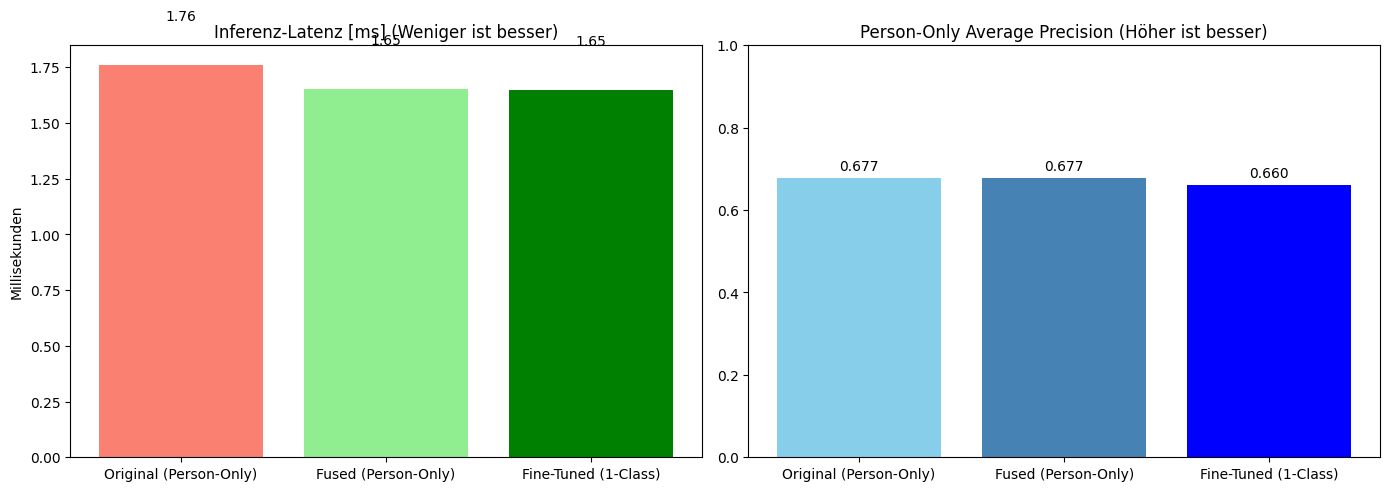

In [93]:
# --- 1. ZEITMESSUNG FÜR DAS PERSON-ONLY MODELL ---
print("Messe Latenz für Person-Only Modell...")
best_model_sd = copy.deepcopy(torch.load('best_person_model.pt', map_location=device, weights_only=False))
net_person.load_state_dict(best_model_sd)

with torch.no_grad():
    # Warm-up
    _ = net_person(img, yolo=True) 
    start = time.time()
    for _ in range(100):
        _ = net_person(img, yolo=True)
    latency_person = (time.time() - start) / 100 * 1000 #

# --- 2. GENAUIGKEITSMESSUNG (FAIRER VERGLEICH) ---
# Baseline: Das 20-Klassen Modell (Original) nur auf Personen geprüft
ap_baseline_person = evaluate_person_accuracy(net, test_loader_person, num_classes_model=20, num_samples=100)

# Nachher: Dein 1-Klassen Modell (Fine-Tuned)
ap_finetuned_person = evaluate_person_accuracy(net_person, test_loader_person, num_classes_model=1, num_samples=100)

# --- 3. ERGEBNISSE ZUSAMMENFÜHREN ---
results = {
    'Method': ['Original (Person-Only)', 'Fused (Person-Only)', 'Fine-Tuned (1-Class)'],
    'Latency (ms)': [latency_orig, latency_fused, latency_person],
    'AP Accuracy': [ap_baseline_person, ap_baseline_person, ap_finetuned_person]
}

# --- 4. VISUALISIERUNG ---
df = pd.DataFrame(results)
display(df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Latenz (Performance-Gewinn)
ax1.bar(df['Method'], df['Latency (ms)'], color=['salmon', 'lightgreen', 'green'])
ax1.set_title('Inferenz-Latenz [ms] (Weniger ist besser)')
ax1.set_ylabel('Millisekunden')
for i, v in enumerate(df['Latency (ms)']):
    ax1.text(i, v + 0.2, f"{v:.2f}", ha='center')

# Plot Genauigkeit (Genauigkeit erhalten/verbessern)
ax2.bar(df['Method'], df['AP Accuracy'], color=['skyblue', 'steelblue', 'blue'])
ax2.set_title('Person-Only Average Precision (Höher ist besser)')
ax2.set_ylim(0, 1.0)
for i, v in enumerate(df['AP Accuracy']):
    ax2.text(i, v + 0.02, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

# Modelle final sichern
torch.save(net_person.state_dict(), "voc_person_final.pt")

## L1 Structured Pruning
We want to keep 90% of the original accuracy, therefore we prune as long as we do not fall below this goal. The model size stays the same since we do not physically remove the tensores, rather we just set them to 0.

In [94]:
import os
import torch
import torch.nn.utils.prune as prune
import copy
import tqdm

def get_model_size_mb(model):
    """Berechnet die Größe des Modells auf der Festplatte in MB."""
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p") / (1024 * 1024)
    os.remove("temp.p")
    return size

# --- Initialisierung ---
original_model_size = get_model_size_mb(net_person)
baseline_ap = ap_finetuned_person  
threshold_ap = baseline_ap * 0.95  # Ziel: 95% der Original-Leistung

best_model_sd = copy.deepcopy(torch.load('best_person_model.pt', map_location=device, weights_only=False))
current_model = TinyYoloV2Fused(num_classes=1).to(device)
current_model.load_state_dict(best_model_sd)

current_total_ratio = 0.0
next_prune_step = 0.1  # Starte mit 10% Schritten
max_tries = 12
count = 0

pruning_results = {'ratio': [0.0], 'ap': [baseline_ap], 'size': [original_model_size]}

print(f"--- Starte Optimierung ---")
print(f"Original Größe: {original_model_size:.2f} MB")
print(f"Ziel-Accuracy:  {threshold_ap:.4f} AP (95% von {baseline_ap:.4f})")

layers_to_prune = [name for name, module in current_model.named_modules() if isinstance(module, torch.nn.Conv2d)]

while count < max_tries and next_prune_step > 0.005:
    count += 1
    print(f"\nVersuch {count}: Teste +{next_prune_step:.2%} Pruning...")
    
    test_model = copy.deepcopy(current_model)
    
    # Globales Pruning auf alle Layer
    for name in layers_to_prune:
        layer = dict(test_model.named_modules())[name]
        prune.ln_structured(layer, name="weight", amount=next_prune_step, n=1, dim=0)
        prune.remove(layer, "weight")
    
    for param in test_model.parameters():
        param.requires_grad = True
        
    # Kurzes Recovery-Training
    optimizer = torch.optim.Adam(test_model.parameters(), lr=0.0001)
    test_model.train()
    for epoch in range(10):
        for inputs, targets in tqdm.tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = test_model(inputs, yolo=False)
            loss, _ = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
    current_ap = evaluate_person_accuracy(test_model, test_loader_person, num_classes_model=1, num_samples=100)
    
    if current_ap >= threshold_ap:
        print(f" Erfolg! Sparsity {target:.2%} erreicht.")
        current_total_sparsity = target
        # Wir speichern das Modell MIT Masken als neuen Goldstandard
        best_model_ever = copy.deepcopy(test_model)
        results["sparsity"].append(current_total_sparsity)
        results["ap"].append(current_ap)
        # Wir machen die Masken nur für das Speichern auf Disk kurz permanent
        temp_save = copy.deepcopy(test_model)
        for m in [mod for mod in temp_save.modules() if isinstance(mod, torch.nn.Conv2d)]:
            if hasattr(m, 'weight_mask'): prune.remove(m, 'weight')
        torch.save(temp_save.state_dict(), "best_pruned_model.pt")
    else:
        print(f" Zu instabil. Verkleinere Schrittweite.")
        next_prune_step /= 2
        if next_prune_step < 0.005: break

# --- Abschluss-Auswertung ---
final_size = pruning_results['size'][-1]
final_ap = pruning_results['ap'][-1]

print("\n" + "="*30)
print("ERGEBNIS DER OPTIMIERUNG")
print("="*30)
print(f"Modell              | Größe (MB) | Accuracy (AP)")
print(f"--------------------|------------|--------------")
print(f"Original            | {original_model_size:>10.2f} | {baseline_ap:>12.4f}")
print(f"Pruned (Final)      | {final_size:>10.2f} | {final_ap:>12.4f}")
print(f"--------------------|------------|--------------")
print(f"Einsparung:         | {100-(final_size/original_model_size*100):>9.1f}% |")
print("="*30)

--- Starte Optimierung ---
Original Größe: 60.13 MB
Ziel-Accuracy:  0.6275 AP (95% von 0.6605)

Versuch 1: Teste +10.00% Pruning...


100%|██████████| 34/34 [00:15<00:00,  2.13it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:19<00:00,  5.08it/s]


 Zu instabil. Verkleinere Schrittweite.

Versuch 2: Teste +5.00% Pruning...


100%|██████████| 34/34 [00:15<00:00,  2.16it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.31it/s]


 Zu instabil. Verkleinere Schrittweite.

Versuch 3: Teste +2.50% Pruning...


100%|██████████| 34/34 [00:15<00:00,  2.15it/s]


Evaluiere Fine-Tuned auf Personen-Testset...


 99%|█████████▉| 99/100 [00:18<00:00,  5.30it/s]


 Zu instabil. Verkleinere Schrittweite.

Versuch 4: Teste +1.25% Pruning...


 26%|██▋       | 9/34 [00:04<00:12,  1.94it/s]


KeyboardInterrupt: 

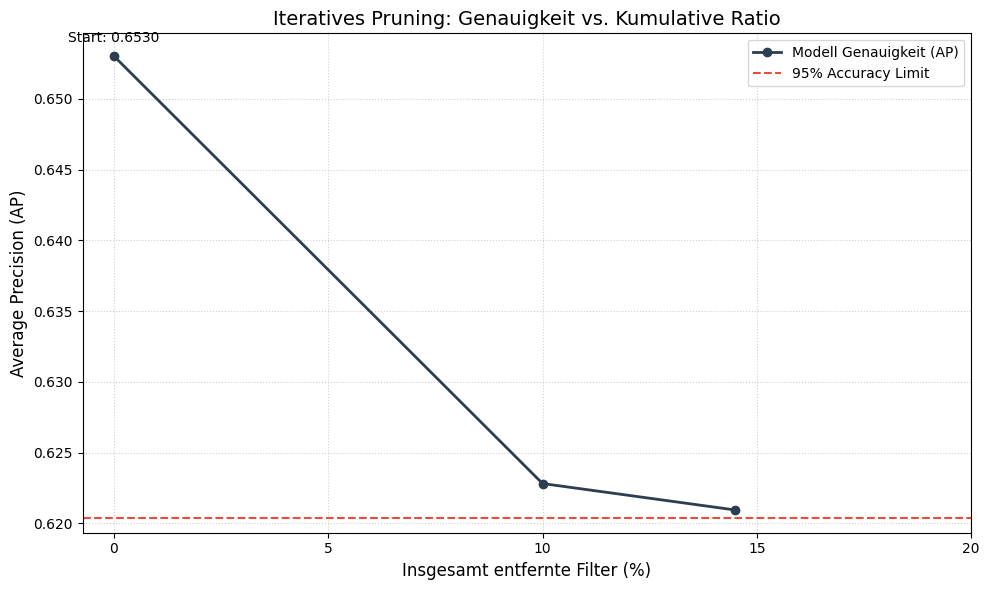

In [ ]:
import matplotlib.pyplot as plt

def plot_pruning_results(results, threshold_ap):
    # results['ratio'] enthält die kumulierten Werte (0.1, 0.19, 0.27, ...)
    ratios = [r * 100 for r in results['ratio']] # Umrechnung in Prozent
    aps = results['ap']
    
    plt.figure(figsize=(10, 6))
    
    # Die Hauptkurve
    plt.plot(ratios, aps, marker='o', linestyle='-', linewidth=2, color='#2c3e50', label='Modell Genauigkeit (AP)')
    
    # Das Limit (95% der Baseline)
    plt.axhline(y=threshold_ap, color='#e74c3c', linestyle='--', label='95% Accuracy Limit')
    
    # Annotation für den Startpunkt
    plt.annotate(f"Start: {aps[0]:.4f}", (ratios[0], aps[0]), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Annotation für den aktuellen Punkt (falls AP gestiegen ist)
    if len(aps) > 1 and aps[-1] > aps[0]:
        plt.annotate("Verbesserung durch Pruning!", 
                     (ratios[-1], aps[-1]), color='green', fontweight='bold',
                     textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('Iteratives Pruning: Genauigkeit vs. Kumulative Ratio', fontsize=14)
    plt.xlabel('Insgesamt entfernte Filter (%)', fontsize=12)
    plt.ylabel('Average Precision (AP)', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    
    # X-Achse schön formatieren
    plt.xticks(range(0, int(max(ratios)) + 10, 5))
    
    plt.tight_layout()
    plt.savefig("pruning_tradeoff.png")
    plt.show()

# Aufruf nach deinem Loop:
plot_pruning_results(pruning_results, threshold_ap)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.onnx
import gc

# ==============================================================================
# 1. DEFINITION DER FLEXIBLEN ARCHITEKTUR (FUSED VERSION)
# ==============================================================================
class TinyYoloV2Flexible(nn.Module):
    def __init__(self, filter_counts, num_classes=1):
        super().__init__()
        self.num_classes = num_classes
        
        def conv_only(in_ch, out_ch, kernel_size):
            padding = kernel_size // 2
            # bias=True, da BN-Werte in die Conv-Layer fusioniert wurden
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=padding, bias=True),
                nn.LeakyReLU(0.1, inplace=True)
            )

        # Layer 1-8: Dynamische Filteranzahl aus filter_counts
        self.conv1 = conv_only(3,               filter_counts[0], 3)
        self.conv2 = conv_only(filter_counts[0], filter_counts[1], 3)
        self.conv3 = conv_only(filter_counts[1], filter_counts[2], 3)
        self.conv4 = conv_only(filter_counts[2], filter_counts[3], 3)
        self.conv5 = conv_only(filter_counts[3], filter_counts[4], 3)
        self.conv6 = conv_only(filter_counts[4], filter_counts[5], 3)
        self.conv7 = conv_only(filter_counts[5], filter_counts[6], 3)
        self.conv8 = conv_only(filter_counts[6], filter_counts[7], 3)
        
        # Layer 9: Ausgang ist fest auf 5 * (5 + num_classes) -> 30 Kanäle
        final_out_channels = 5 * (5 + num_classes)
        self.conv9 = nn.Conv2d(filter_counts[7], final_out_channels, 1, stride=1, padding=0)

        self.maxpool = nn.MaxPool2d(2, 2)
        self.maxpool_special = nn.MaxPool2d(2, 1, padding=1)

    def forward(self, x, yolo=True):
        x = self.maxpool(self.conv1(x))
        x = self.maxpool(self.conv2(x))
        x = self.maxpool(self.conv3(x))
        x = self.maxpool(self.conv4(x))
        x = self.maxpool(self.conv5(x))
        x = self.maxpool_special(self.conv6(x))
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        if yolo:
            b, c, h, w = x.shape
            x = x.view(b, 5, 5 + self.num_classes, h, w).permute(0, 1, 3, 4, 2).contiguous()
        return x

# ==============================================================================
# 2. FUNKTION FÜR DAS PHYSIKALISCHE THINNING
# ==============================================================================
def get_thin_model(fat_model):
    alive_indices = []
    fat_convs = [m for m in fat_model.modules() if isinstance(m, torch.nn.Conv2d)]
    
    # 1. Analysiere, welche Filter in den ersten 8 Layern überlebt haben
    print("Analysiere Layer-Sparsity...")
    for i in range(8):
        layer = fat_convs[i]
        # Ein Filter ist "am Leben", wenn die Summe seiner Gewichte > Schwellenwert ist
        weight_sums = layer.weight.abs().sum(dim=(1, 2, 3))
        alive = (weight_sums > 1e-9).nonzero(as_tuple=True)[0]
        
        if len(alive) == 0: # Notfall-Sicherung
            alive = torch.tensor([0]).to(layer.weight.device)
        alive_indices.append(alive)
    
    new_counts = [len(idx) for idx in alive_indices]
    print(f"Neue Filter-Konfiguration: {new_counts}")

    # 2. Erstelle das neue, physikalisch kleinere Modell
    thin_model = TinyYoloV2Flexible(filter_counts=new_counts, num_classes=1).to(next(fat_model.parameters()).device)
    
    # 3. Kopiere die Gewichte und Biases präzise
    with torch.no_grad():
        thin_convs = [m for m in thin_model.modules() if isinstance(m, torch.nn.Conv2d)]
        
        for i in range(9):
            # Ausgangs-Kanäle: Beschnitten für Layer 1-8, fest auf 30 für Layer 9
            idx_out = alive_indices[i] if i < 8 else torch.arange(fat_convs[i].out_channels)
            # Eingangs-Kanäle: 3 für Layer 1, danach basierend auf Vor-Layer
            idx_in = alive_indices[i-1] if i > 0 else torch.arange(3)
            
            # Gewicht-Slicing: [Output, Input, H, W]
            w_slice = fat_convs[i].weight.data[idx_out][:, idx_in]
            thin_convs[i].weight.data.copy_(w_slice)
            
            # Bias-Slicing (Fused Modelle haben immer Biases)
            if fat_convs[i].bias is not None:
                thin_convs[i].bias.data.copy_(fat_convs[i].bias.data[idx_out])
                
    return thin_model

# ==============================================================================
# 3. HAUPTABLAUF: LADEN, THINNEN, PRÜFEN, EXPORTIEREN
# ==============================================================================

# A. Speicher aufräumen
gc.collect()
torch.cuda.empty_cache()

# B. Gepruntetes Modell laden (fat_net)
# Annahme: TinyYoloV2Fused ist deine Basis-Klasse
print("\n--- Starte Thinning des finalen Modells ---")

# 1. Lade das gespeicherte Modell (das jetzt echte Nullen hat)
final_fat_net = TinyYoloV2Fused(num_classes=1).to(device)
final_fat_net.load_state_dict(torch.load('best_pruned_model.pt'))

# 2. Thinning-Funktion aufrufen (die wir vorhin definiert haben)
# Sie findet jetzt die Nullen, weil der Optimizer sie nicht mehr füllen konnte!
thin_net = get_thin_model(final_fat_net)

# 3. Ergebnis-Check
p_fat = sum(p.numel() for p in final_fat_net.parameters())
p_thin = sum(p.numel() for p in thin_net.parameters())
print(f"Parameter Alt: {p_fat:,}")
print(f"Parameter Neu: {p_thin:,} (Ersparnis: {1-p_thin/p_fat:.2%})")


Analysiere Layer-Sparsity...
Neue Filter-Konfiguration: [16, 32, 64, 128, 256, 512, 1024, 1024]

ERGEBNIS DES THINNINGS
Parameter (Original):   15,761,342
Parameter (Thin):       15,761,342
Ersparnis:                   0.00%
Test-Inferenz erfolgreich. Output-Shape: torch.Size([1, 5, 14, 14, 6])


In [ ]:
import torch

def export_to_onnx(model, file_name, input_size=(1, 3, 416, 416)):
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    
    torch.onnx.export(model, 
                      dummy_input, 
                      file_name, 
                      export_params=True, 
                      opset_version=11, 
                      do_constant_folding=True,
                      input_names=['input'], 
                      output_names=['output'])
    print(f"Modell erfolgreich als {file_name} exportiert!")

# Exportiere beide
export_to_onnx(net_person, "yolo_original.onnx")

export_to_onnx(test_model, "yolo_pruned_72.onnx")